In [1]:
# EfficientNet-B7 achieves new state-of-the-art 84.4% top-1 / 97.1% top-5 accuracy year 2019 while being 8.4x
# smaller than the best existing CNN, e.g. EfficientNet-B1 is 7.6x smaller and 5.7x faster than ResNet-152.
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# Print the current date and time in the format:
# "YYYY-MM-DD HH:MM:SS.microseconds"
import datetime
def print_current_datetime():
    datetime_string = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    print("CDT(Current Date and Time):", datetime_string)

In [2]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Configuration
path_train = 'kaggle-dataset/train'
path_validation = 'kaggle-dataset/validation'
img_height = 456
img_width = 456
batch_size = 8, # 64 preferred (depending on the dataset size)

# Create an instance of the ImageDataGenerator class
train_datagen_ins = ImageDataGenerator(rescale=1/255)
val_datagen_ins = ImageDataGenerator(rescale=1/255)

# The ImageDataGenerator class will automatically load the images
# and generate one-hot encoded labels based on default directories.
# Note: Unlike the folders, jpg files can have any names.
'''
kaggle-dataset/
    train/
        class1/
            img1.jpg
            img2.jpg
            ...
        class2/
            img1.jpg
            img2.jpg
            ...
        class3/
            img1.jpg
            img2.jpg
'''
# Load the training data and labels from a directory
train_generator = train_datagen_ins.flow_from_directory(
    path_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    #class_mode="binary" # The labels are binary (either 0 or 1)
)

'''
kaggle-dataset/
    validation/
        class1/
            img1.jpg
            img2.jpg
            ...
        class2/
            img1.jpg
            img2.jpg
            ...
        class3/
            img1.jpg
            img2.jpg
'''
val_generator = val_datagen_ins.flow_from_directory(
    path_validation,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    #class_mode="binary" # The labels are binary (either 0 or 1)
)

# Get a batch of data from the train_generator
X_batch, y_batch = next(train_generator)

# Check the shape of the data and labels
print('Data shape:', X_batch.shape)
print('Labels shape:', y_batch.shape)

# Check the range of pixel values
print('Min pixel value:', X_batch.min())
print('Max pixel value:', X_batch.max())

# Check the class indices and class names
print('Class indices:', train_generator.class_indices)
print('Class names:', list(train_generator.class_indices.keys()))

2023-03-23 10:47:07.610910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 10:47:07.610940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gbike/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 24 images belonging to 3 classes.
Found 6 images belonging to 3 classes.
Data shape: (8, 456, 456, 3)
Labels shape: (8, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Class indices: {'class1': 0, 'class2': 1, 'class3': 2}
Class names: ['class1', 'class2', 'class3']


In [3]:
# Load the pre-trained model
base_model = EfficientNetB5(weights='imagenet', include_top=False)

# Add custom layers for classification
# for 3 different classes to classify
base_model_output = base_model.output
base_model_output = GlobalAveragePooling2D()(base_model_output)
predictions = Dense(3, activation='softmax')(base_model_output)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
#model.summary()

print_current_datetime()

# Compile the model and freeze the base model layers
model.compile(optimizer='adam', loss='categorical_crossentropy')
for layer in base_model.layers:
    layer.trainable = False

# Train the model on new layers for few epochs
model.fit(train_generator, epochs=10, verbose=1)

print_current_datetime()

# Compile the model and unfreeze some of the base model layers and continue training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Train the model on more layers for a few epochs
history = model.fit(train_generator, validation_data=val_generator, epochs=100, verbose=1)

model.save('efficientnet_finetuned_epoch_100.h5')

print_current_datetime()

2023-03-23 10:47:14.535809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-23 10:47:14.535833: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-23 10:47:14.535850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-255-120-161): /proc/driver/nvidia/version does not exist
2023-03-23 10:47:14.536030: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CDT(Current Date and Time): 2023-03-23 10:47:18.881760
Epoch 1/10
3/3 [==============================] - 44s 9s/step - loss: 0.6740
Epoch 2/10
3/3 [==============================] - 25s 8s/step - loss: 0.0331
Epoch 3/10
3/3 [==============================] - 25s 8s/step - loss: 0.0206
Epoch 4/10
3/3 [==============================] - 25s 8s/step - loss: 0.0146
Epoch 5/10
3/3 [==============================] - 25s 8s/step - loss: 0.2080
Epoch 6/10
3/3 [==============================] - 25s 8s/step - loss: 0.4616
Epoch 7/10
3/3 [==============================] - 25s 8s/step - loss: 0.4887
Epoch 8/10
3/3 [==============================] - 25s 8s/step - loss: 0.1190
Epoch 9/10
3/3 [==============================] - 24s 8s/step - loss: 0.3482
Epoch 10/10
3/3 [==============================] - 25s 8s/step - loss: 0.2351
CDT(Current Date and Time): 2023-03-23 10:51:45.993446
Epoch 1/100
3/3 [==============================] - 20s 4s/step - loss: 1.6911 - accuracy: 0.3333 - val_loss: 1.4264 - v

3/3 [==============================] - 7s 2s/step - loss: 1.1309 - accuracy: 0.2917 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 54/100
3/3 [==============================] - 7s 2s/step - loss: 1.1287 - accuracy: 0.2083 - val_loss: 1.1018 - val_accuracy: 0.3333
Epoch 55/100
3/3 [==============================] - 7s 2s/step - loss: 1.1161 - accuracy: 0.2500 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 56/100
3/3 [==============================] - 7s 2s/step - loss: 1.1078 - accuracy: 0.1667 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 57/100
3/3 [==============================] - 7s 2s/step - loss: 1.0802 - accuracy: 0.4167 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 58/100
3/3 [==============================] - 7s 2s/step - loss: 1.1432 - accuracy: 0.2083 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 59/100
3/3 [==============================] - 7s 2s/step - loss: 1.0998 - accuracy: 0.3333 - val_loss: 1.1008 - val_accuracy: 0.3333
Epoch 60/100
3/3 [======================

/home/gbike/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


CDT(Current Date and Time): 2023-03-23 11:03:09.697961


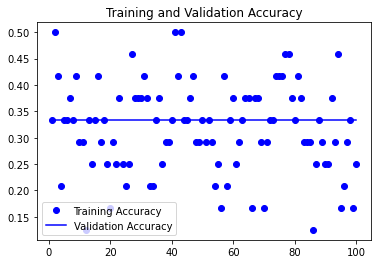

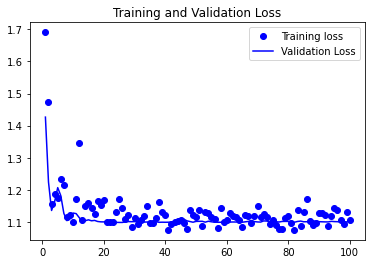

In [4]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [6]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np

model_loaded = load_model('efficientnet_finetuned_epoch_100.h5')

img_path = 'image.jpg'
img_resized = tf.keras.preprocessing.image.load_img(img_path, target_size=(456, 456)) # EfficientNetB5
img_vectorized = tf.keras.preprocessing.image.img_to_array(img_resized)
img_vectorized = tf.keras.applications.efficientnet.preprocess_input(img_vectorized)
img_vectorized = np.expand_dims(img_vectorized, axis=0)

predicted_result = model_loaded.predict(img_vectorized)
print(predicted_result)

# Get the predicted label name: class1(0), class2(1), class3(2)
label_map = {0: "Cat", 1: "Dog", 2: "Human"}
predicted_label_id = np.argmax(predicted_result)
predicted_label_name = label_map[predicted_label_id]

print(predicted_label_name)

[[0.39633936 0.39123732 0.21242337]]
Cat
